In [ ]:
#适度编程益脑 过度编程伤身
#合理安排时间 享受健康生活

# Traditional AI II

In this notebook, you will learn how to implement and compare the search algorithms: Breadth-First Search (BFS), Depth-First Search (DFS), and A* Search, along with their applications in problem-solving.

## Authors
- Xiao Fu

## Learning Outcomes

- **Breadth-First Search (BFS):** Learn how BFS explores graphs level by level and how it can be used to find the shortest path in unweighted graphs.
- **Depth-First Search (DFS):** Understand how DFS explores as far as possible along each branch before backtracking, and its applications in traversing trees and graphs.
  
- **A * Search Algorithm:** Implement the A* algorithm, which uses heuristics to find the most promising path, and understand how it optimises search by combining the cost to reach a node and an estimated cost to the goal.


## Source
- https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96
- https://matteo-tosato7.medium.com/exploring-the-depths-solving-mazes-with-a-search-algorithm-c15253104899
- https://medium.com/swlh/solving-mazes-with-depth-first-search-e315771317ae
- https://medium.com/@luthfisauqi17_68455/artificial-intelligence-search-problem-solve-maze-using-breadth-first-search-bfs-algorithm-255139c6e1a3

- https://levelup.gitconnected.com/a-star-a-search-for-solving-a-maze-using-python-with-visualization-b0cae1c3ba92

## Task

1. Create maze
2. Implement DFS (last week)
2. Implement BFS (last week)
2. Implement A* (**this week**)

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import heapq
from queue import Queue
from abc import ABC, abstractmethod
import time

## Creating Maze

A maze can be represented as a two-dimensional array, where walls are denoted by $1$ and paths by $0$.

In [2]:
def create_maze(dim):
    # Create a grid filled with walls
    maze = np.ones((dim*2+1, dim*2+1))

    # Define the starting point
    x, y = (0, 0)
    maze[2*x+1, 2*y+1] = 0

    # Initialize the stack with the starting point
    stack = [(x, y)]
    while len(stack) > 0:
        x, y = stack[-1]

        # Define possible directions
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < dim and ny < dim and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()
            
    # Create an entrance and an exit
    maze[1, 0] = 0
    maze[-2, -1] = 0

    return maze

In [3]:
temp_maze = create_maze(5)
temp_maze

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## Drawing the Maze 


In [4]:
def draw_maze(maze, path=None):
    fig, ax = plt.subplots(figsize=(10,10))
    
    # Set the border color to white
    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    ax.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')
    
    # Draw the solution path if it exists
    if path is not None:
        x_coords = [x[1] for x in path]
        y_coords = [y[0] for y in path]
        ax.plot(x_coords, y_coords, color='red', linewidth=2)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Draw entry and exit arrows
    ax.arrow(0, 1, .4, 0, fc='green', ec='green', head_width=0.3, head_length=0.3)
    ax.arrow(maze.shape[1] - 1, maze.shape[0]  - 2, 0.4, 0, fc='blue', ec='blue', head_width=0.3, head_length=0.3)
    
    plt.show()

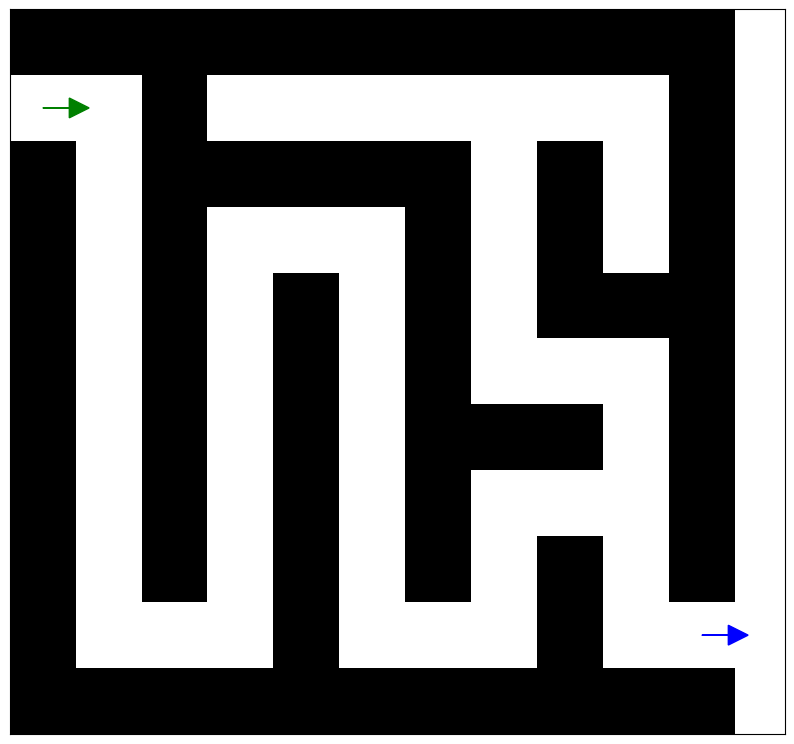

In [5]:
draw_maze(temp_maze)

## PathFinder

The `PathFinder` class is an abstract base class designed to provide a common structure for implementing various pathfinding algorithms in a maze. It serves as a blueprint for subclasses like BFS, DFS, and A* pathfinders, encapsulating shared properties and behaviors.

### Purpose

- **Maze Representation**: Accepts a 2D NumPy array where `0` represents a passable path and `1` represents a wall.
- **Start and End Points**: Initializes default starting and ending positions within the maze, typically avoiding the outer walls.
- **Movement Directions**: Defines possible movements in four cardinal directions—up, down, left, and right.
- **Visited Cells Tracking**: Utilizes a boolean array to keep track of visited cells.

### Key Components

- **Initialization (`__init__`)**:
  - Sets up the maze and initial parameters.
  - Initializes the `visited` array to track explored cells.
  - Marks the starting position as visited.

- **Abstract Method (`find_path`)**:
  - Declared using the `@abstractmethod` decorator, requiring subclasses to implement this method.
  - Defines the interface for the pathfinding logic to find a path from the start to the end point.


By extending the `PathFinder` class, you can create specialized pathfinding algorithms that leverage the common setup while focusing on the unique aspects of each algorithm.


In [6]:
class PathFinder(ABC):
    def __init__(self, maze):
        """
        Initialize the PathFinder with a maze.

        Parameters:
        - maze (numpy.ndarray): 2D array representing the maze where 0 is passable and 1 is a wall.
        """
        self.maze = maze
        self.start = (1, 1)
        self.end = (maze.shape[0] - 2, maze.shape[1] - 2)
        self.directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        self.visited = np.zeros_like(maze, dtype=bool)
        self.visited[self.start] = True

    @abstractmethod
    def find_path(self):
        """
        Abstract method to find a path from start to end in the maze.
        Must be implemented by subclasses.
        """
        pass
    
    def get_visited_count(self):
        """
        Count all of the visited points to analyze the performance of the algorithms.

        Returns:
        - int: The total number of points visited during pathfinding.
        """
        return np.sum(self.visited)

## Breadth-First Search (BFS)

The **Breadth-First Search (BFS)** algorithm is used to search a graph data structure for a node that meets a set of criteria. It starts at the root of the graph and visits all nodes at the current depth level before moving on to nodes at the next depth level.

### How BFS Works

1. **Start at the root node**.
2. **Visit all neighbor nodes** at the current depth.
3. **Proceed to the next level** of nodes.
4. **Repeat** until the goal node is found or all nodes are visited.

### Characteristics of BFS

- Explores nodes level by level.
- Uses a **queue** to keep track of nodes to visit.
- Guarantees the **shortest path** in an unweighted graph.

In [7]:

class BFSPathFinder(PathFinder):
    def find_path(self):
        """
        Find the shortest path using Breadth-First Search (BFS).

        Returns:
        - list of tuples representing the path from start to end, or None if no path exists.
        """
        
        queue = Queue()
        queue.put((self.start, [self.start]))
        
        while not queue.empty():
            current_node, path = queue.get()
            
            for dx, dy in self.directions:
                next_node = (current_node[0] + dx, current_node[1] + dy)
                
                if next_node == self.end:
                    return path + [next_node]
                
                if (0 <= next_node[0] < self.maze.shape[0] and
                    0 <= next_node[1] < self.maze.shape[1] and
                    self.maze[next_node] == 0 and
                    not self.visited[next_node]):
                    
                    self.visited[next_node] = True
                    queue.put((next_node, path + [next_node]))
                    
        return None

## Depth-First Search (DFS)

**Depth-First Search (DFS)** is a graph/tree traversal algorithm that explores as far as possible along each branch before backtracking. It follows a path as far as it can until it either reaches the goal or has nowhere else to go.

### How DFS Works

1. **Start at the root node**.
2. **Explore as deep as possible** along each branch.
3. **Backtrack** when no unvisited adjacent nodes remain.
4. **Repeat** until the goal node is found or all nodes are visited.

### Characteristics of DFS

- Explores as deep as possible before backtracking.
- Uses a **stack** (often via recursion) to keep track of nodes.
- Does **not guarantee** the shortest path.



It's like running as far as you can in one direction until you hit a wall. This helps clear up any lingering confusion.


In [8]:
class DFSPathFinder(PathFinder):
    def find_path(self):
        """
        Find a path using Depth-First Search (DFS).

        Returns:
        - list of tuples representing the path from start to end, or None if no path exists.
        """
        
        stack = [(self.start, [self.start])]
        
        while stack:
            current_node, path = stack.pop()
            
            if current_node == self.end:
                return path
            
            for dx, dy in self.directions:
                next_node = (current_node[0] + dx, current_node[1] + dy)
                
                if (0 <= next_node[0] < self.maze.shape[0] and
                    0 <= next_node[1] < self.maze.shape[1] and
                    self.maze[next_node] == 0 and
                    not self.visited[next_node]):
                    
                    self.visited[next_node] = True
                    stack.append((next_node, path + [next_node]))
        
        return None

## A* Search Algorithm

The **A-Star (A\*) Search Algorithm** is an intelligent algorithm used to solve graph problems. Unlike DFS and BFS, A* is an **informed search algorithm**, meaning it takes into account the position or location of the goal while searching for it. This allows it to search fewer nodes to reach the goal.

### How A* Works

1. **Start at the root node**.
2. **Evaluate nodes** using a cost function \( f(n) = g(n) + h(n) \):
   - \( g(n) \): Cost from the start node to the current node.
   - \( h(n) \): Estimated cost from the current node to the goal (heuristic).
3. **Select the node** with the lowest \( f(n) \) to explore next.
4. **Repeat** until the goal node is reached.

### Characteristics of A*

- Uses a **priority queue** to select the next node based on the lowest cost.
- Incorporates **heuristics** to guide the search efficiently.
- Finds the shortest path more effectively than uninformed algorithms.

In [24]:
class AStarPathFinder(PathFinder):
    def heuristic(self, a, b):
        """
        Calculate the Manhattan distance heuristic.

        Parameters:
        - a (tuple): Current node coordinates.
        - b (tuple): Goal node coordinates.

        Returns:
        - int: Manhattan distance between a and b.
        """
        return abs(a[0] - b[0]) + abs(a[1] - b[1]) #曼哈顿距离

    def find_path(self):
        """
        Find the shortest path using the A* Search Algorithm.

        Returns:
        - list of tuples representing the path from start to end, or None if no path exists.
        """
        import heapq
        import numpy as np
        maze  = self.maze
        H, W  = maze.shape
        start = self.start
        goal  = getattr(self, "goal", getattr(self, "end", None))
        if goal is None:
            raise ValueError("终点未设置：需要 self.goal 或 self.end")
        OPEN_VAL = maze[start]

        if start == goal:
            if hasattr(self, "visited"):
                self.visited[start] = True
            return [start]
        if not (0 <= start[0] < H and 0 <= start[1] < W):
            return None
        if not (0 <= goal[0] < H and 0 <= goal[1] < W):
            return None
        if maze[goal] != OPEN_VAL:
            return None
    
        # open_list: [(f, g, (x, y))]
        open_list = []
        g0 = 0
        f0 = g0 + self.heuristic(start, goal)
        heapq.heappush(open_list, (f0, g0, start))
    
        came_from = {} #找爹
        # g_score 记录从起点到当前节点的最小代价
        g_score = {start: 0}
        closed = np.zeros_like(maze, dtype=bool)
        
        while open_list:
            _, g, current = heapq.heappop(open_list)

            if closed[current]:
                continue
            closed[current] = True
            if hasattr(self, "visited"):
                self.visited[current] = True
        
            if current == goal:
                path = [current] #败者食尘 BITE THE DUST 負けて死ね
                while current in came_from:
                    current = came_from[current]
                    path.append(current)
                path.reverse()
                return path

            cx, cy = current
            for dx, dy in self.directions:
                nx, ny = cx + dx, cy + dy
                if not (0 <= nx < H and 0 <= ny < W):
                    continue
                if closed[nx, ny]:
                    continue
                if maze[nx, ny] != OPEN_VAL:
                    continue
                
                neighbor = (nx, ny)
                tentative_g = g + 1  # 每步代价为 1
                if tentative_g < g_score.get(neighbor, float("inf")):
                    g_score[neighbor] = tentative_g
                    f = tentative_g + self.heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f, tentative_g, neighbor))
                    came_from[neighbor] = current

        """      
         
            .::-------------------------------:---------==-=-     
            ::-=+++++++++*+++++++++=++++=++++*+++++++++***#*##-    
           .:-==++++=+=+**++++++++++++++-+++++*+++++******####*.   
          .:-=+=++++++++*+++++++++++++++::++++*++++*+*****#####+   
          ::-=++++++++++*+++++++++++++++:.=+++*++++********#####-  
          :-=+++++++++++*+++++++++++++++:..++**************#####*  
         .:-=++++++++++++++++*****++++++...-+++*+**+*******######: 
         ::-+++++++++++++++++++++++++++=....++**+++++******######- 
         ::=+++++++++++++++++*+++++++++=....=+++=+++++*****######= 
         ::=+++++++++++++++++++++++++++-....:+++-++++=+*****#####+ 
         ::+++++++++++++++++*++++++++++:.....+++.++++-+*****#####+ 
         ::++++++++++++++++++++++*+++++......=+*.=***+******#####+ 
         ::=++++++++++++++++++++++*+++=......-*#*###**%#****#####- 
         .:=+++++++++++++*##########*+-......=+%%***=:+#%#**#####. 
         .:-++++++++++++##*+*++++**+*+:........=%%#*#. .--*#####:  
          :-+++++++++++##++==+##+#*++=........-*#%#:+. ..-######   
          ::++++++++++++*++=#+#%+-*............-:-::: ...=######   
          :-++*++++++++++-:.+:::.:: ............:........*######=  
         :-++*++*+++++++=.. .:..........................-########+ 
         -=++*++******++=...............................+######### 
         =+++*++*+*******:.............................-########## 
         ++++*++*+++++***:............................-+########## 
         ++++**+*+++++*++-...........................::-#########* 
         *+=+**+***+++*+++=...........................-*######%##- 
         *%==+**********+***:.......................:+###**##%@%@+ 
         -%%=-+*+**+*********+-...................:+###***#%@@@@@+ 
         +*%@#+=++++++**********=:..............:+###%%%@@@@@@@@@+ 
         *@@@@@%-=+++++#++=+**#*#**::.........-*#%%%@@@@@@@@@@@@@= 
         *@@@@@@--+++++*++=-=*%##***::::::..:---+%%%%@@@@@@@@@@@@= 
        
         @A_E Arcadia_Ebenide
        
        """
        
        return None

## Comparison between three ways

Maze Size: 10
BFS Time: 0.0010s, Visited Nodes: 103
DFS Time: 0.0000s, Visited Nodes: 141
A* Time: 0.0000s, Visited Nodes: 92
---
Maze Size: 25
BFS Time: 0.0020s, Visited Nodes: 629
DFS Time: 0.0030s, Visited Nodes: 1231
A* Time: 0.0010s, Visited Nodes: 574
---
Maze Size: 50
BFS Time: 0.0150s, Visited Nodes: 2280
DFS Time: 0.0374s, Visited Nodes: 4755
A* Time: 0.0070s, Visited Nodes: 2192
---
Maze Size: 75
BFS Time: 0.0266s, Visited Nodes: 3169
DFS Time: 0.1359s, Visited Nodes: 11126
A* Time: 0.0190s, Visited Nodes: 3036
---
Maze Size: 100
BFS Time: 0.3130s, Visited Nodes: 16816
DFS Time: 0.3434s, Visited Nodes: 18926
A* Time: 0.0485s, Visited Nodes: 16112
---
Maze Size: 150
BFS Time: 0.6387s, Visited Nodes: 22887
DFS Time: 1.8533s, Visited Nodes: 41512
A* Time: 0.0690s, Visited Nodes: 22832
---
Maze Size: 200
BFS Time: 9.4171s, Visited Nodes: 78321
DFS Time: 6.8221s, Visited Nodes: 64543
A* Time: 0.2448s, Visited Nodes: 78196
---


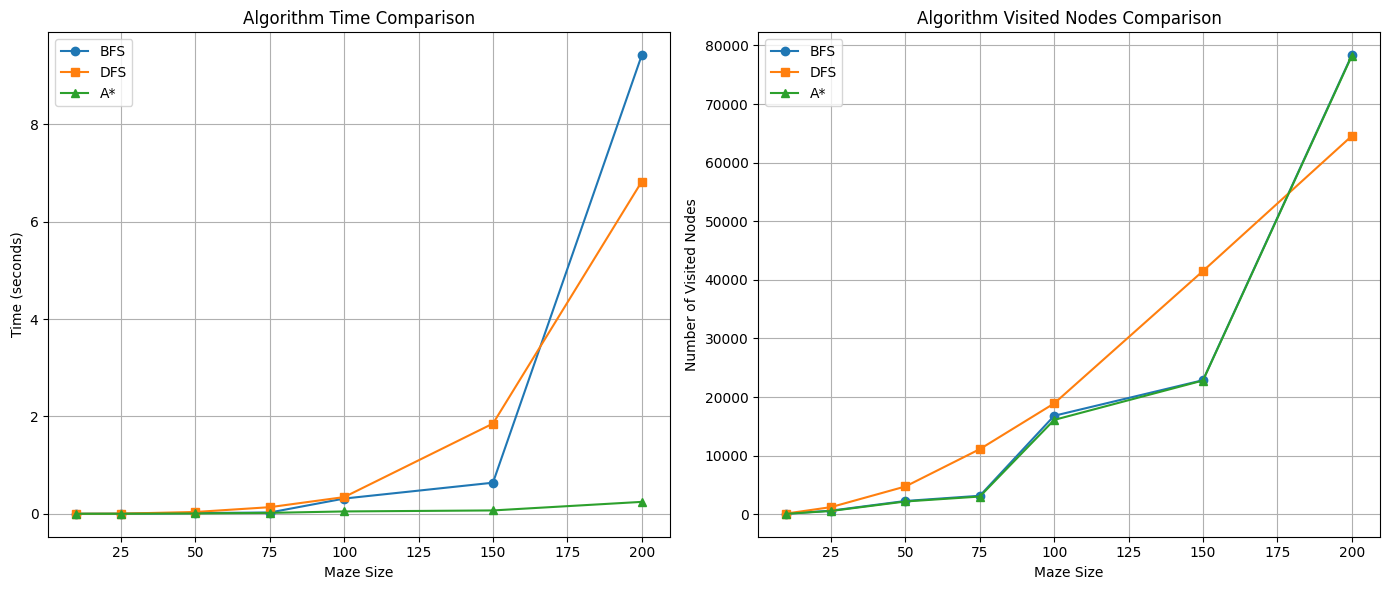

In [25]:
maze_sizes = [10,25,50,75,100,150,200]

# Lists to store results
bfs_times = []
dfs_times = []
astar_times = []

bfs_visited_counts = []
dfs_visited_counts = []
astar_visited_counts = []

for size in maze_sizes:
    maze = create_maze(size)
    
    # BFS
    bfs = BFSPathFinder(maze)
    start = time.time()
    bfs_path = bfs.find_path()
    end = time.time()
    bfs_time = end - start
    bfs_visited = bfs.get_visited_count()
    bfs_times.append(bfs_time)
    bfs_visited_counts.append(bfs_visited)
    
    # DFS
    dfs = DFSPathFinder(maze)
    start = time.time()
    dfs_path = dfs.find_path()
    end = time.time()
    dfs_time = end - start
    dfs_visited = dfs.get_visited_count()
    dfs_times.append(dfs_time)
    dfs_visited_counts.append(dfs_visited)
    
    # A*
    astar = AStarPathFinder(maze)
    start = time.time()
    astar_path = astar.find_path()
    end = time.time()
    astar_time = end - start
    astar_visited = astar.get_visited_count()
    astar_times.append(astar_time)
    astar_visited_counts.append(astar_visited)

    print(f"Maze Size: {size}")
    print(f"BFS Time: {bfs_time:.4f}s, Visited Nodes: {bfs_visited}")
    print(f"DFS Time: {dfs_time:.4f}s, Visited Nodes: {dfs_visited}")
    print(f"A* Time: {astar_time:.4f}s, Visited Nodes: {astar_visited}")
    print("---")

# Plotting Time and Visited Nodes
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Time Plot
axs[0].plot(maze_sizes, bfs_times, marker='o', label='BFS')
axs[0].plot(maze_sizes, dfs_times, marker='s', label='DFS')
axs[0].plot(maze_sizes, astar_times, marker='^', label='A*')
axs[0].set_xlabel('Maze Size')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_title('Algorithm Time Comparison')
axs[0].legend()
axs[0].grid(True)

# Visited Nodes Plot
axs[1].plot(maze_sizes, bfs_visited_counts, marker='o', label='BFS')
axs[1].plot(maze_sizes, dfs_visited_counts, marker='s', label='DFS')
axs[1].plot(maze_sizes, astar_visited_counts, marker='^', label='A*')
axs[1].set_xlabel('Maze Size')
axs[1].set_ylabel('Number of Visited Nodes')
axs[1].set_title('Algorithm Visited Nodes Comparison')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## An example of path finder

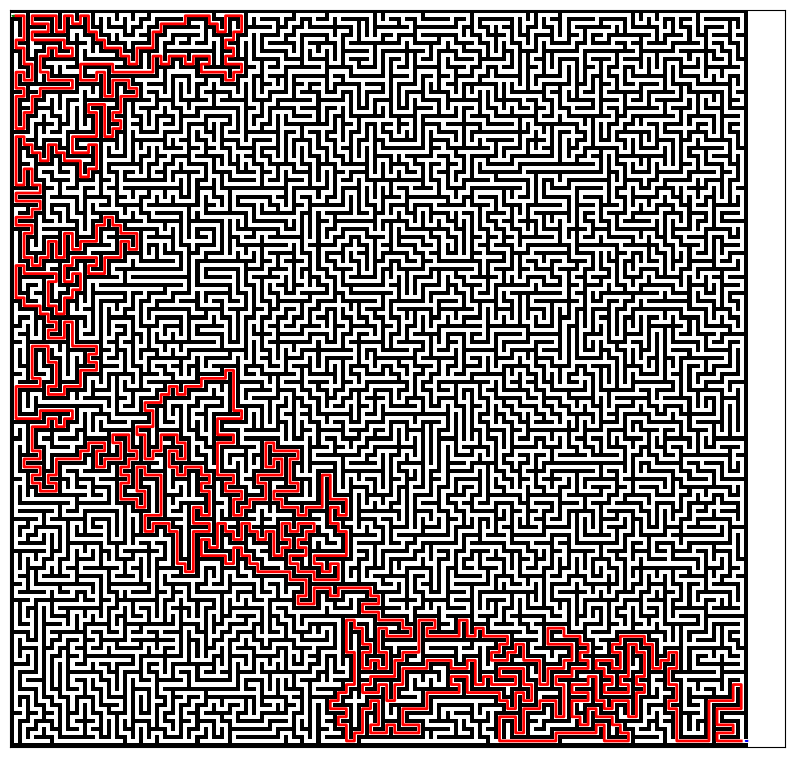

In [17]:
maze = create_maze(91)
astar = AStarPathFinder(maze)
astar_path = astar.find_path()
draw_maze(maze, astar_path)


## Comparison Summary

| Algorithm | Data Structure Used | Shortest Path Guarantee    | Informed Search |
|-----------|---------------------|----------------------------|-----------------|
| **BFS**   | Queue               | Yes (in unweighted graphs) | No              |
| **DFS**   | Stack or Recursion  | No                         | No              |
| **A\***   | Priority Queue      | Yes                        | Yes             |

---

## Conclusion

Understanding these search algorithms is crucial for efficiently solving various graph-related problems. BFS and DFS are foundational algorithms that explore graphs differently, while A* leverages heuristics to find the shortest path more intelligently.